In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
# These packages are required by the visualization utils
import seaborn as sns  
from sklearn.manifold import TSNE

import vae_utils

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: ignored

# Project 1, part 2: Variational Autoencoder (60 pt)
In this notebook you will implement the Variational Autoencoder (VAE) that we discussed in Lecture 3.

## Your task
Complete the missing code. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Do not add or modify any code outside of the following comment blocks
```
##########################################################
# YOUR CODE HERE
.....
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.


The following things are **NOT** allowed:
- Using additional `import` statements
- Using the `torch.distributions` package
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

## Load the MNIST dataset

In [0]:
# device = 'cuda'
device = 'cpu'  # uncomment this line to run the model on the CPU
batch_size = 128
dataset = datasets.MNIST 
if device == 'cuda':
    train_loader = torch.utils.data.DataLoader(
        dataset('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        dataset('data', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=1000, shuffle=True, num_workers=1, pin_memory=True
    )
elif device == 'cpu':
    train_loader = torch.utils.data.DataLoader(
        dataset('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        dataset('data', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=1000, shuffle=True,
    )


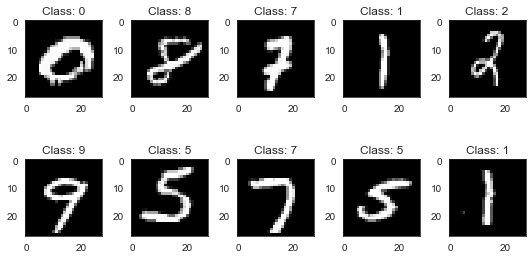

In [0]:
# Visualize a few random samples from the dataset
vae_utils.visualize_mnist(train_loader)

## Task 1: Encoder (10 pt)
The encoder network produces the parameters of the variational distribution (Slide 102). 
In our case, the variational distribution $q_{\boldsymbol{\phi}^{(i)}}(\mathbf{z}^{(i)})$ is multivariate normal with diagonal covariance, so we encoder needs to produce its mean and the (diagonal of the) covariance matrix.
The encoder has the following architecture
<img src="img/encoder.png" alt="Encoder" style="width: 200px;"/>
The encoder produces the parameters $\boldsymbol{\mu}^{(i)} \in \mathbb{R}^L$ and $\log \boldsymbol{\sigma}^{(i)} \in \mathbb{R}^L$ for each sample $i$ in the mini batch. 
Note that $\log \boldsymbol{\sigma}^{(i)}$ can be negative, we convert it into a diagonal positive-definite covariance matrix as $\boldsymbol{\Sigma}^{(i)} = \operatorname{diag}(\exp(\log \boldsymbol{\sigma}^{(i)}))^2)$

## Task 2: Reparametrization sampling (10 pt)
Given the parameters $\boldsymbol{\mu}^{(i)}$ and $\log \boldsymbol{\sigma}^{(i)}$ of the variational distribution, we need to generate samples $\mathbf{z}^{(i)} \sim q_{\boldsymbol{\phi}^{(i)}}(\mathbf{z}^{(i)}) = \mathcal{N}(\mathbf{z}^{(i)} | \boldsymbol{\mu}^{(i)}, \boldsymbol{\Sigma}^{(i)})$ to estimate the ELBO. 
We draw one sample $\mathbf{z}^{(i)}$ for each instance $i$ in the mini-batch (Slide 104).
It's important to draw samples using reparametrization here, so that it's possible to obtain gradient w.r.t. the parameters of the encoder.

Functions `torch.normal` or `torch.Tensor.normal_` might be useful here.

## Task 3: Decoder (10 pt)
The decoder takes the samples $\mathbf{z}^{(i)}$ and produces the parameters $\boldsymbol{\theta}^{(i)} \in \mathbb{R}^D$ of the data likelihood $p_{\boldsymbol{\theta}^{(i)}}(\mathbf{x}^{(i)}|\mathbf{z}^{(i)})$.
We use the following simple architecture for the decoder

<img src="img/decoder.png" alt="Decoder" style="width: 150px;"/>

Our data $\mathbf{x}^{(i)} \in \{0, 1\}^D$ is binary, so we use Bernoulli likelihood (Slide 95)
$$p_{\boldsymbol{\theta}^{(i)}}(\mathbf{x}^{(i)}|\mathbf{z}^{(i)}) = \prod_{j=1}^D \left(\theta_{j}^{(i)}\right)^{x_{j}^{(i)}} \left(1 - \theta_{j}^{(i)}\right)^{1 - x_{j}^{(i)}}$$
Recall that the **negative log-likelihood** of the Bernoulli model is also called binary cross entropy.

The parameters $\theta_{j}^{(i)}$ must be in $(0, 1)$, which we enforce using the sigmoid function.

## Task 4: KL divergence (5 pt)
To compute the ELBO, we will need to compute the KL divergence. 
$$\mathbb{KL}(q_{\boldsymbol{\phi}^{(i)}}(\mathbf{z}^{(i)}) || p(\mathbf{z}^{(i)}))$$
Where $p(\mathbf{z}^{(i)})$ is the standard L-dimensional normal distribution (zero mean, identity covariance).
This can be done in closed form (Slide 99).

## Task 5: ELBO (15 pt)
Finally, we can compute the ELBO using all the methods that we implemented above.
ELBO for a single sample $\mathbf{x}^{(i)} \in \{0, 1\}^D$ is computed as
$$\mathcal{L}_i(\boldsymbol{\psi}, \boldsymbol{\lambda}) = \mathbb{E}_{\mathbf{z}^{(i)} \sim q_{\boldsymbol{\phi}^{(i)}} (\mathbf{z}^{(i)})}\left[\log p_{\boldsymbol{\theta}^{(i)}}(\mathbf{x}^{(i)} | \mathbf{z}^{(i)})\right] - \mathbb{KL}(q_{\boldsymbol{\phi}^{(i)}}(\mathbf{z}^{(i)}) || p(\mathbf{z}))$$

In practice it's more efficient to compute the ELBO for a minibatch $\mathcal{B}$ of samples 
$$\mathcal{L}(\boldsymbol{\psi}, \boldsymbol{\lambda}) = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x}^{(i)} \in \mathcal{B}} \mathcal{L}_i(\boldsymbol{\psi}, \boldsymbol{\lambda})$$
where the variational parameters $\boldsymbol{\phi}^{(i)}$ are produced by the **encoder network** $f_{\boldsymbol{\psi}}$ (i.e. $\boldsymbol{\phi}^{(i)} = f_{\boldsymbol{\psi}}(\mathbf{x}^{(i)})$),
and the likelihood parameters $\boldsymbol{\theta}^{(i)}$ are produced by the **decoder network** $g_{\boldsymbol{\lambda}}$ (i.e. $\boldsymbol{\theta}^{(i)} = g_{\boldsymbol{\lambda}}(\mathbf{x}^{(i)})$).

Overview of this procedure is provided on Slide 103.

## Task 6: Generating new data (10 pt)
We can generate new samples using the procedure described on Slide 108.
Function `torch.bernoulli` might be useful here.

In [0]:
class VAE(nn.Module):
    def __init__(self, obs_dim, latent_dim, hidden_dim=100):
        """Initialize the VAE model.
        
        Args:
            obs_dim: Dimension of the observed data x, int
            latent_dim: Dimension of the latent variable z, int
            hidden_dim: Hidden dimension of the encoder/decoder networks, int
        """
        super().__init__()
        self.latent_dim = latent_dim
        # Trainable layers of the encoder
        self.linear1 = nn.Linear(obs_dim, hidden_dim)
        self.linear21 = nn.Linear(hidden_dim, latent_dim)
        self.linear22 = nn.Linear(hidden_dim, latent_dim)
        # Trainable layers of the decoder
        self.linear3 = nn.Linear(latent_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, obs_dim)
    
    def encoder(self, x):
        """Obtain the parameters of q(z) for a batch of data points.
        
        Args:
            x: Batch of data points, shape [batch_size, obs_dim]
        
        Returns:
            mu: Means of q(z), shape [batch_size, latent_dim]
            logsigma: Log-sigmas of q(z), shape [batch_size, latent_dim]
        """
        ##########################################################
        # YOUR CODE HERE
        # Linear1 -> ReLU -> Linear21 -> mu
        #                 -> Linear22 -> logsigma
        h1 = F.relu(self.linear1(x)) # h1 shape [batch_size, hidden_dim]
        mu = self.linear21(h1)
        logsigma = self.linear22(h1)
#         logsigma = torch.diagonal(torch.square(torch.exp(logsigma)))
#         logsigm2 = torch.rsqrt(logvar)# Covert logsigma into a diagonal positive-definite covariance matrix
#         logsigma = torch.diag_embed(logsigma)
        return mu, logsigma
        ##########################################################
    
    def sample_with_reparam(self, mu, logsigma):
        """Draw sample from q(z) with reparametrization.
        
        We draw a single sample z_i for each data point x_i.
        
        Args:
            mu: Means of q(z) for the batch, shape [batch_size, latent_dim]
            logsigma: Log-sigmas of q(z) for the batch, shape [batch_size, latent_dim]
        
        Returns:
            z: Latent variables samples from q(z), shape [batch_size, latent_dim]
        """
        ##########################################################
        # YOUR CODE HERE
        std = torch.exp(logsigma) #.abs()
        eps = torch.randn_like(std)
        z = mu + eps*std  
        return z
        ##########################################################
    
    def decoder(self, z):
        """Convert sampled latent variables z into observations x.
        
        Args:
            z: Sampled latent variables, shape [batch_size, latent_dim]
        
        Returns:
            theta: Parameters of the conditional likelihood, shape [batch_size, obs_dim]
        """
        ##########################################################
        # YOUR CODE HERE
        # Linear3 -> ReLU -> Linear4 -> sigmoid -> theta
        # h3 = F.relu(self.linear3(z.cuda()))
        # theta = torch.sigmoid(self.linear4(h3))
        h3 = F.relu(self.linear3(z))
        theta = torch.sigmoid(self.linear4(h3))

        # print(type(theta))
        return theta
        ##########################################################
    
    def kl_divergence(self, mu, logsigma):
        """Compute KL divergence KL(q_i(z)||p(z)) for each q_i in the batch.
        
        Args:
            mu: Means of the q_i distributions, shape [batch_size, latent_dim]
            logsigma: Logarithm of standard deviations of the q_i distributions,
                      shape [batch_size, latent_dim]
        
        Returns:
            kl: KL divergence for each of the q_i distributions, shape [batch_size]
        """
        ##########################################################
        # YOUR CODE HERE
        var = torch.exp(logsigma)**2
        kl = 0.5 * torch.sum(var + mu.pow(2) - var.log() -1, dim=1)
        
        return kl
        ##########################################################
    
    def elbo(self, x):
        """Estimate the ELBO for the mini-batch of data.
        
        Args:
            x: Mini-batch of the observations, shape [batch_size, obs_dim]
        
        Returns:
            elbo_mc: MC estimate of ELBO for each sample in the mini-batch, shape [batch_size]
        """
        ##########################################################
#         mu, logsigma = self.encoder(x)
#         KL = self.kl_divergence(mu, logsigma)
#         theta = self.decoder(self.sample_with_reparam(mu, logsigma))
#         log_p = (torch.pow(theta, x)*torch.pow(1-theta, 1-x)).log_()
# #         log_p = x*torch.log(theta) + (1 - x) * torch.log(1 - theta)
#         log_p = log_p.sum(dim=1)
# #         log_p = torch.mean(x*torch.log(theta) + (1 - x) * torch.log(1 - theta), 1)
#         elbo_mc = torch.mean(log_p - KL)
#         return elbo_mc
        
#         # YOUR CODE HERE
        mu, logsigma = self.encoder(x)
        z = self.sample_with_reparam(mu, logsigma)
        theta = self.decoder(z) # theta is the probability for x = 1
#         print(x*torch.log(theta) + (1 - x) * torch.log(1 - theta))
        log_pxz = torch.sum(x*torch.log(theta) + (1 - x) * torch.log(1 - theta), 1)
        elbo_mc = torch.mean(log_pxz) - self.kl_divergence(mu, logsigma) # need to find expectation of log_p, how? : by using torch.mean
        return elbo_mc
        ##########################################################
        
    def sample(self, num_samples):
        """Generate samples from the model.
        
        Args:
            num_samples: Number of samples to generate.
        
        Returns:
            x: Samples generated by the model, shape [num_samples, obs_dim]
        """
        ##########################################################
        # YOUR CODE HERE
        z = torch.zeros([num_samples, self.latent_dim]).bernoulli_(0.5)
        x = self.decoder(z)
        return x
    
#         shape = torch.rand((num_samples, latent_dim))
#         z = torch.randn_like(shape)
#         theta = self.decoder(z)
#         # torch.bernoulli(input, *, generator=None, out=None)
#         # input (Tensor) – the input tensor of probability values for the Bernoulli distribution
#         x = torch.bernoulli(theta)
#         return x
        ##########################################################

In [0]:
obs_dim = 784  # MNIST images are of shape [1, 28, 28]
latent_dim = 32  # Size of the latent variable z
hidden_dim = 400  # Size of the hidden layer in the encoder / decoder

vae = VAE(obs_dim, latent_dim, hidden_dim).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [0]:
max_epochs = 5
display_step = 100
for epoch in range(max_epochs):
    print(f'Epoch {epoch}')
    for ix, batch in enumerate(train_loader):
        x, y = batch
        x = x.view(x.shape[0], obs_dim).to(device)  # we flatten the image into 1D array
        opt.zero_grad()
        # We want to maximize the ELBO, so we minimize the negative ELBO
        loss = -vae.elbo(x).mean(-1)
        loss.backward()
        opt.step()
        
        if ix % display_step == 0:
            print(f'  loss = {loss.item():.2f}')

Epoch 0
  loss = 549.41
  loss = 187.53
  loss = 157.43
  loss = 148.81
  loss = 133.25
Epoch 1
  loss = 131.19
  loss = 129.85
  loss = 118.95
  loss = 124.45
  loss = 121.92
Epoch 2
  loss = 116.08
  loss = 113.72
  loss = 116.59
  loss = 113.21
  loss = 114.40
Epoch 3
  loss = 111.55
  loss = 114.46
  loss = 115.87
  loss = 109.50
  loss = 111.23
Epoch 4
  loss = 113.62
  loss = 107.40
  loss = 108.15
  loss = 107.02
  loss = 111.86


### Visualize samples generated by the model

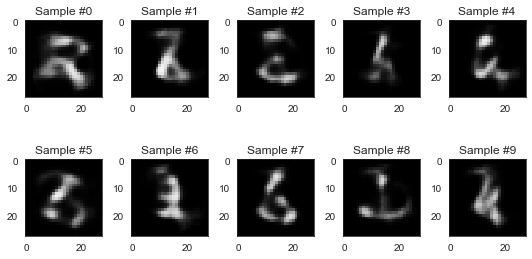

In [0]:
x = vae.sample(10).view(-1, 28, 28).detach().cpu().numpy()
vae_utils.visualize_vae_samples(x)

### Visualize the embeddings produced by the model
Here, we visualize the embeddings learned by the encoder using the following procedure
1. Take a mini-batch `x` (shape `[batch_size, obs_dim]`)
2. Pass `x` through the encoder 
```
mu, logsigma = vae.encoder(x)
```
3. Visualize the mean `mu` for each sample using t-SNE.

<Figure size 720x504 with 0 Axes>

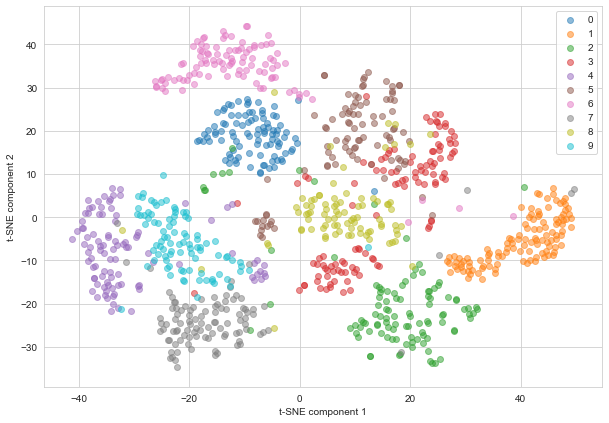

In [0]:
x, y = next(iter(test_loader))
x = x.view(x.shape[0], obs_dim).to(device)
plt.figure(figsize=[10, 7])
vae_utils.visualize_embeddings(vae, x, y)

As we can see, the encoder learned to assign similar means to the images that belong to the same class. That means, if two samples $x_i$ and $x_j$ belong to the same class, the means $\mu_i$ and $\mu_j$ of their variational distributions $q_i(z_i)$ and $q_j(z_j)$ are nearby, so $z_i$ and $z_j$ will likely be close as well.